In [1]:
# Parameters (overridden during execution)
EPOCHS = 25
RUN_ID = 1
OUT_DIR = "/kaggle/working/outputs"

In [2]:
!pip install torchinfo
!pip install --quiet torchview graphviz

In [3]:
import os
import math
import time
import random
import multiprocessing
from datetime import timedelta
from pathlib import Path
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from glob import glob

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG, display

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

from timm.models.vision_transformer import VisionTransformer, PatchEmbed
from torchinfo import summary
from torchview import draw_graph

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import random_split
from collections import Counter

In [6]:
# -------------------------
# Config (dynamic params)
# -------------------------
BATCH_SIZE = 6
IMG_SIZE   = 224

# data = np.load("/kaggle/input/pneumoniamnist.npz")
data = np.load("/content/pneumoniamnist.npz")

X_train, y_train = data["train_images"], data["train_labels"]
X_val,   y_val   = data["val_images"],   data["val_labels"]
X_test,  y_test  = data["test_images"],  data["test_labels"]

# -------------------------
# Label normalization
# -------------------------
def normalize_labels(labels: np.ndarray) -> np.ndarray:
    labels = np.asarray(labels)

    if labels.ndim == 2:
        if labels.shape[1] == 1:
            labels = labels.squeeze(axis=1)
        else:
            labels = labels.argmax(axis=1)

    return labels.astype(int)

y_train = normalize_labels(y_train)
y_val   = normalize_labels(y_val)
y_test  = normalize_labels(y_test)

print("Train images shape:", X_train.shape)
print("Val images shape:  ", X_val.shape)
print("Test images shape: ", X_test.shape)

Train images shape: (3882, 28, 28)
Val images shape:   (524, 28, 28)
Test images shape:  (624, 28, 28)


In [7]:
from torch.utils.data import Dataset, DataLoader

# -------------------------
# PyTorch Dataset
# -------------------------
class PneumoniaDataset(Dataset):
    def __init__(self, images, labels, img_size):
        self.img_size = img_size

        # Convert once
        self.images = torch.from_numpy(images).float()
        self.labels = torch.from_numpy(labels).long()

        # Ensure channel dimension
        if self.images.ndim == 3:
            self.images = self.images.unsqueeze(1)  # (N, 1, H, W)

        # Convert grayscale -> RGB
        if self.images.shape[1] == 1:
            self.images = self.images.repeat(1, 3, 1, 1)  # (N, 3, H, W)

        # Resize once
        if self.images.shape[2] != img_size or self.images.shape[3] != img_size:
            self.images = F.interpolate(
                self.images,
                size=(img_size, img_size),
                mode="bilinear",
                align_corners=False
            )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# -------------------------
# Datasets & Loaders
# -------------------------
train_dataset = PneumoniaDataset(X_train, y_train, IMG_SIZE)
val_dataset   = PneumoniaDataset(X_val,   y_val,   IMG_SIZE)
test_dataset  = PneumoniaDataset(X_test,  y_test,  IMG_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

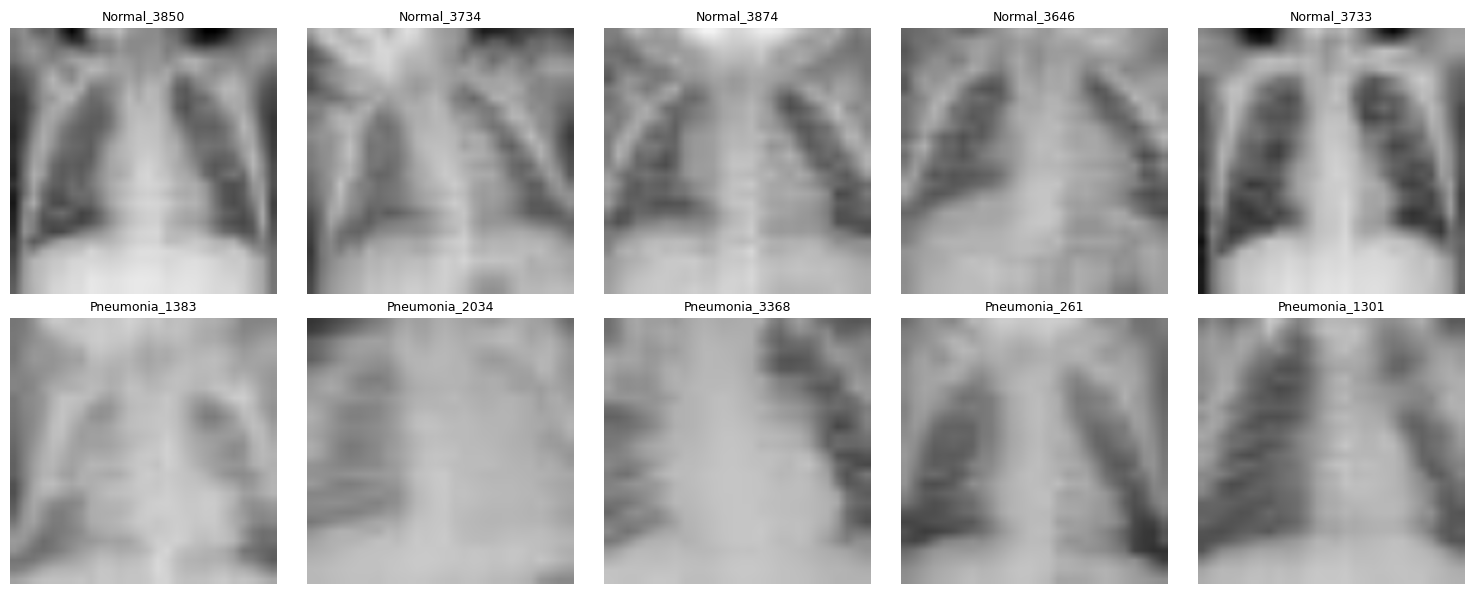

In [8]:
def show_random_images_per_class(
    dataset,
    class_names,
    n_per_class=5,
    seed=42,
    image_names=None
):
    """
    Displays n random images per class in an m x n grid.
    If image_names is None, uses ClassName_index.
    """

    random.seed(seed)
    torch.manual_seed(seed)

    labels = dataset.labels.cpu().numpy()
    images = dataset.images.cpu()
    num_classes = len(class_names)

    class_indices = [
        np.where(labels == c)[0]
        for c in range(num_classes)
    ]

    fig, axes = plt.subplots(
        num_classes,
        n_per_class,
        figsize=(3 * n_per_class, 3 * num_classes),
        squeeze=False
    )

    for cls in range(num_classes):
        idxs = class_indices[cls]
        k = min(n_per_class, len(idxs))
        selected = np.random.choice(idxs, size=k, replace=False)

        for col, idx in enumerate(selected):
            img = images[idx].permute(1, 2, 0).numpy()
            img = img / 255.0  # correct float range for imshow

            ax = axes[cls, col]
            ax.imshow(img)
            ax.axis("off")

            # Image title
            if image_names is not None:
                title = image_names[idx]
            else:
                title = f"{class_names[cls]}_{idx}"

            ax.set_title(title, fontsize=9)

            if col == 0:
                ax.set_ylabel(
                    class_names[cls],
                    rotation=90,
                    fontsize=12,
                    labelpad=10
                )

    plt.tight_layout()
    plt.show()

class_names = ["Normal", "Pneumonia"]

show_random_images_per_class(
    train_dataset,
    class_names=class_names,
    n_per_class=5
)

In [9]:
class TwoMaxMinusMinPool2d(nn.Module):
    """
    Pooling layer that computes:
        output = (2 * max_pool) - min_pool

    Uses only optimized max-pooling kernels.
    Computational cost ~ 2× max pooling.
    Output shape matches standard pooling.
    """

    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()

        # Match PyTorch pooling semantics
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding

    def forward(self, x):
        # Fast max pooling (optimized C++/CUDA)
        max_pool = F.max_pool2d(
            x,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )

        # Fast min pooling via negation trick
        min_pool = -F.max_pool2d(
            -x,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )

        # Final contrast-enhanced response
        return (2.0 * max_pool) - min_pool

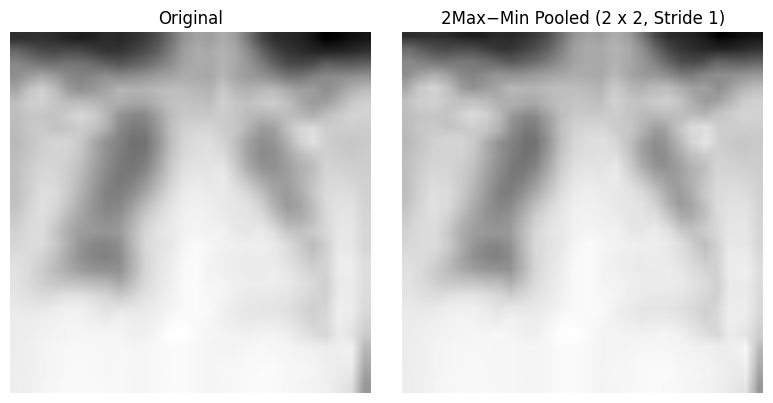

In [10]:
KERNEL_SIZE = 2
STRIDE = 1

# Get one batch
images, labels = next(iter(train_loader))

# Take first image only
img = images[0:1]  # shape: (1, C, H, W)

pool = TwoMaxMinusMinPool2d(kernel_size=KERNEL_SIZE, stride=STRIDE)
pool.eval()

with torch.no_grad():
    pooled = pool(img)

# Convert to numpy for display
img_np = img[0].cpu().numpy()
pooled_np = pooled[0].cpu().numpy()

# Pick one channel to visualize
ch = 0

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(img_np[ch], cmap="gray")
axs[0].set_title("Original")
axs[0].axis("off")

axs[1].imshow(pooled_np[ch], cmap="gray")
axs[1].set_title(F"2Max−Min Pooled ({KERNEL_SIZE} x {KERNEL_SIZE}, Stride {STRIDE})")
axs[1].axis("off")

plt.tight_layout()
plt.show()

In [11]:
class CNN_ViT_Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        pretrained_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        num_blocks1 = len(pretrained_model.features)

        # Freeze first half
        for param in pretrained_model.features[:num_blocks1 // 2].parameters():
            param.requires_grad = False

        self.mobilenet_feature_blocks_1 = nn.Sequential(*pretrained_model.features[:num_blocks1 - 3])
        self.mobilenet_block_2nd_last = pretrained_model.features[num_blocks1 - 3]
        self.mobilenet_block_mid = pretrained_model.features[num_blocks1 - 2]
        self.mobilenet_block_last = pretrained_model.features[num_blocks1 - 1]

        ch_2nd_last = self.mobilenet_block_2nd_last.out_channels  # 160
        ch_last     = self.mobilenet_block_last.out_channels      # 1280
        ch_mid      = self.mobilenet_block_mid.out_channels       # 320
        ch_concat   = ch_last + ch_2nd_last                        # 1440


        self.cnn_to_vit_adapter = nn.Sequential(
            nn.Conv2d(ch_mid, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Upsample(size=(14, 14), mode="bilinear", align_corners=False),

            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Upsample(size=(28, 28), mode="bilinear", align_corners=False),

            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Upsample(size=(56, 56), mode="bilinear", align_corners=False),
        )

        self.vit_encoder1 = VisionTransformer(
            img_size=56,
            patch_size=8,
            in_chans=16,
            num_classes=0,
            embed_dim=48,
            depth=2,
            num_heads=4,
            mlp_ratio=2,
            qkv_bias=True,
            norm_layer=nn.LayerNorm,
        )
        self.vit_encoder1.head = nn.Identity()

        # Overlapping patches
        old_proj = self.vit_encoder1.patch_embed.proj
        self.vit_encoder1.patch_embed.proj = nn.Conv2d(
            old_proj.in_channels,
            old_proj.out_channels,
            kernel_size=8,
            stride=4,
            bias=old_proj.bias is not None,
        )

        # Adjust positional embeddings
        img_h, img_w = self.vit_encoder1.patch_embed.img_size
        dummy = torch.zeros(1, old_proj.in_channels, img_h, img_w)
        with torch.no_grad():
            _, _, h, w = self.vit_encoder1.patch_embed.proj(dummy).shape

        num_patches = h * w
        self.vit_encoder1.patch_embed.num_patches = num_patches
        self.vit_encoder1.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, self.vit_encoder1.embed_dim)
        )
        nn.init.trunc_normal_(self.vit_encoder1.pos_embed, std=0.02)


        self.twomax_minus_min_pool = TwoMaxMinusMinPool2d(kernel_size=2, stride=1)
        self.post_pool_gelu = nn.GELU()


        self.vit_encoder2 = VisionTransformer(
            img_size=28,
            patch_size=7,
            in_chans=32,
            num_classes=0,
            embed_dim=48,
            depth=2,
            num_heads=4,
            mlp_ratio=2,
            qkv_bias=True,
            norm_layer=nn.LayerNorm,
        )
        self.vit_encoder2.head = nn.Identity()


        self.cnn_parallel_head = nn.Sequential(
            nn.Conv2d(ch_concat, 128, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
        )


        self.total_feat_dim = 48 + 48 + 128  # 224
        self.efm_bn = nn.BatchNorm1d(self.total_feat_dim)

        self.classifier_head = nn.Linear(self.total_feat_dim, num_classes)

    def forward(self, x):

        # ---- MobileNet ----
        features_1 = self.mobilenet_feature_blocks_1(x)
        features_2nd_last = self.mobilenet_block_2nd_last(features_1)
        features_mid = self.mobilenet_block_mid(features_2nd_last)
        features_last = self.mobilenet_block_last(features_mid)

        concatenated_cnn_features = torch.cat(
            [features_last, features_2nd_last], dim=1
        )

        # ---- Adapter ----
        x = features_mid
        intermediate = None

        for i, layer in enumerate(self.cnn_to_vit_adapter):
            x = layer(x)
            if i == len(self.cnn_to_vit_adapter) - 5:
                intermediate = x

        vit_input1 = x
        vit_input2 = intermediate

        # ---- ViT 1 ----
        vit_features1 = self.vit_encoder1(vit_input1)

        # ---- ViT 2 ----
        vit_input2 = self.twomax_minus_min_pool(vit_input2)
        vit_input2 = self.post_pool_gelu(vit_input2)
        vit_input2 = F.interpolate(vit_input2, size=(28, 28),
                                   mode="bilinear", align_corners=False)

        vit_features2 = self.vit_encoder2(vit_input2)

        # ---- CNN Branch ----
        cnn_features = self.cnn_parallel_head(concatenated_cnn_features)

        # ---- EFM ----
        combined = torch.cat(
            [vit_features1, vit_features2, cnn_features], dim=1
        )

        combined = self.efm_bn(combined)   # <- EXACT FORMULA

        return self.classifier_head(combined)


In [12]:
model = CNN_ViT_Model(num_classes=2)
summary(model, input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 145MB/s]


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
CNN_ViT_Model                                      [1, 3, 224, 224]          [1, 2]                    --                        Partial
├─Sequential: 1-1                                  [1, 3, 224, 224]          [1, 160, 7, 7]            --                        Partial
│    └─Conv2dNormActivation: 2-1                   [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                            [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─ReLU6: 3-3                             [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─InvertedResidual: 2-2                      

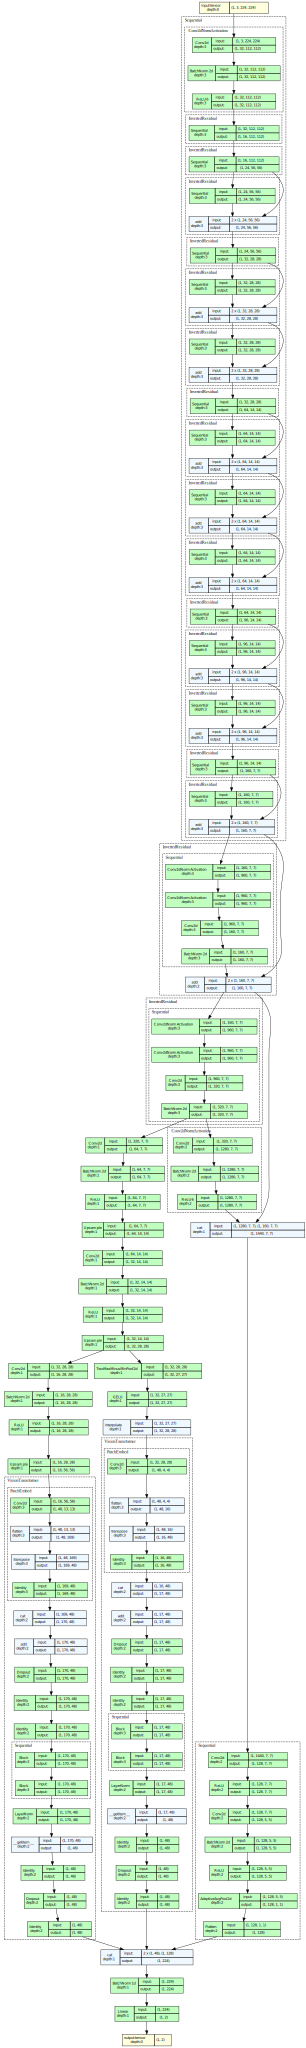

In [13]:
model.to(device)

# Dummy input (can adjust shape based on your model's expected input)
dummy_input = torch.randn(1, 3, 224, 224, device=device)

# Generate the graph — expand_nested=True if model has nested submodules
model_graph = draw_graph(
    model,
    input_data=dummy_input,
    expand_nested=True,
    graph_name="CNN_ViT_Model",
    save_graph=False  # We don't want to save, only display inline
)

# Render to SVG and display inline in the notebook
svg_output = model_graph.visual_graph.pipe(format='svg')
display(SVG(svg_output))

In [14]:
def custom_metrics(y_pred, y_true, loss):
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)

    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0.0

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()

        # Skip AUC if only one class is present
        if np.unique(class_y_true).size < 2:
            continue
        try:
            auc_score = roc_auc_score(class_y_true, class_y_pred)
            auc_scores.append(auc_score)
        except ValueError:
            continue

    auc_avg = np.mean(auc_scores) if auc_scores else 0.0

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [15]:
# Hyperparameters
num_epochs       = EPOCHS
initial_lr       = 2e-4
decay_start_epoch = 10
decay_factor     = 0.97

# Criterion, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Scheduler policy: 1.0 until epoch 11, then 0.98^(epoch - 11)
lr_lambda = lambda epoch: 1.0 if epoch < decay_start_epoch else decay_factor ** (epoch - decay_start_epoch)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [16]:
# Metrics initialization
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric: [] for metric in metric_names}
val_metrics_history = {metric: [] for metric in metric_names}

total_training_time = 0.0
total_validation_time = 0.0

# Training and validation loop
for epoch in range(num_epochs):
    start_time = time.time()

    # Training loop
    model.train()
    total_train_loss = 0.0
    all_train_predictions = []
    all_train_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        all_train_predictions.extend(outputs.detach().cpu().numpy())
        all_train_targets.extend(targets.detach().cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time

    average_train_loss = total_train_loss / len(train_loader)
    all_train_predictions = np.array(all_train_predictions)
    all_train_targets = np.array(all_train_targets)

    train_metrics = custom_metrics(torch.tensor(all_train_predictions), torch.tensor(all_train_targets), average_train_loss)
    training_metrics_line = "Train Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in train_metrics.items()])
    print(training_metrics_line)

    for metric in metric_names:
        train_metrics_history[metric].append(train_metrics[metric])

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    all_val_predictions = []
    all_val_targets = []
    start_val_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model")):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()

            all_val_predictions.extend(outputs.detach().cpu().numpy())
            all_val_targets.extend(targets.detach().cpu().numpy())

    end_val_time = time.time()
    epoch_validation_time = end_val_time - start_val_time
    total_validation_time += epoch_validation_time

    average_val_loss = total_val_loss / len(val_loader)
    all_val_predictions = np.array(all_val_predictions)
    all_val_targets = np.array(all_val_targets)

    val_metrics = custom_metrics(torch.tensor(all_val_predictions), torch.tensor(all_val_targets), average_val_loss)
    validation_metrics_line = "Val Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in val_metrics.items()])
    print(validation_metrics_line)

    for metric in metric_names:
        val_metrics_history[metric].append(val_metrics[metric])

    # Update LR via scheduler rather than manual mutliplication
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch}/{num_epochs} — Loss: {loss.item():.4f} — LR: {current_lr:.6f}")

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / (epoch + 1)
avg_validation_time_per_epoch = total_validation_time / (epoch + 1)
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Epoch [1/25]: 100%|██████████| 647/647 [00:21<00:00, 29.65it/s]


Train Metrics - loss: 0.4108, accuracy: 0.8447, precision: 0.9229, recall: 0.8447, f1_score: 0.8692, specificity: 0.8711, sensitivity: 0.8417, mcc: 0.5084, auc: 0.8873


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 64.10it/s]


Val Metrics - loss: 0.1894, accuracy: 0.9523, precision: 0.9522, recall: 0.9523, f1_score: 0.9515, specificity: 0.8593, sensitivity: 0.9846, mcc: 0.8732, auc: 0.9681
Epoch 0/25 — Loss: 0.3774 — LR: 0.000200


Training Epoch [2/25]: 100%|██████████| 647/647 [00:20<00:00, 30.90it/s]


Train Metrics - loss: 0.1310, accuracy: 0.9673, precision: 0.9669, recall: 0.9673, f1_score: 0.9671, specificity: 0.8222, sensitivity: 0.9834, mcc: 0.8159, auc: 0.9621


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 66.09it/s]


Val Metrics - loss: 0.1148, accuracy: 0.9656, precision: 0.9664, recall: 0.9656, f1_score: 0.9659, specificity: 0.9556, sensitivity: 0.9692, mcc: 0.9119, auc: 0.9904
Epoch 1/25 — Loss: 0.1091 — LR: 0.000200


Training Epoch [3/25]: 100%|██████████| 647/647 [00:22<00:00, 28.76it/s]


Train Metrics - loss: 0.0768, accuracy: 0.9768, precision: 0.9764, recall: 0.9768, f1_score: 0.9765, specificity: 0.8557, sensitivity: 0.9903, mcc: 0.8683, auc: 0.9795


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 64.11it/s]


Val Metrics - loss: 0.1303, accuracy: 0.9466, precision: 0.9486, recall: 0.9466, f1_score: 0.9448, specificity: 0.8074, sensitivity: 0.9949, mcc: 0.8587, auc: 0.9903
Epoch 2/25 — Loss: 0.2151 — LR: 0.000200


Training Epoch [4/25]: 100%|██████████| 647/647 [00:21<00:00, 29.98it/s]


Train Metrics - loss: 0.0520, accuracy: 0.9838, precision: 0.9835, recall: 0.9838, f1_score: 0.9836, specificity: 0.8969, sensitivity: 0.9934, mcc: 0.9083, auc: 0.9936


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 60.73it/s]


Val Metrics - loss: 0.0965, accuracy: 0.9695, precision: 0.9693, recall: 0.9695, f1_score: 0.9692, specificity: 0.9185, sensitivity: 0.9871, mcc: 0.9194, auc: 0.9910
Epoch 3/25 — Loss: 0.1165 — LR: 0.000200


Training Epoch [5/25]: 100%|██████████| 647/647 [00:20<00:00, 31.03it/s]


Train Metrics - loss: 0.0421, accuracy: 0.9871, precision: 0.9870, recall: 0.9871, f1_score: 0.9870, specificity: 0.9201, sensitivity: 0.9946, mcc: 0.9276, auc: 0.9936


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 53.22it/s]


Val Metrics - loss: 0.0944, accuracy: 0.9599, precision: 0.9610, recall: 0.9599, f1_score: 0.9602, specificity: 0.9481, sensitivity: 0.9640, mcc: 0.8975, auc: 0.9918
Epoch 4/25 — Loss: 0.0214 — LR: 0.000200


Training Epoch [6/25]: 100%|██████████| 647/647 [00:20<00:00, 31.19it/s]


Train Metrics - loss: 0.0310, accuracy: 0.9879, precision: 0.9878, recall: 0.9879, f1_score: 0.9878, specificity: 0.9278, sensitivity: 0.9946, mcc: 0.9321, auc: 0.9978


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 49.88it/s]


Val Metrics - loss: 0.0988, accuracy: 0.9637, precision: 0.9639, recall: 0.9637, f1_score: 0.9632, specificity: 0.8889, sensitivity: 0.9897, mcc: 0.9041, auc: 0.9936
Epoch 5/25 — Loss: 0.1201 — LR: 0.000200


Training Epoch [7/25]: 100%|██████████| 647/647 [00:21<00:00, 29.77it/s]


Train Metrics - loss: 0.0268, accuracy: 0.9902, precision: 0.9902, recall: 0.9902, f1_score: 0.9902, specificity: 0.9433, sensitivity: 0.9954, mcc: 0.9453, auc: 0.9970


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 62.32it/s]


Val Metrics - loss: 0.0809, accuracy: 0.9618, precision: 0.9623, recall: 0.9618, f1_score: 0.9611, specificity: 0.8741, sensitivity: 0.9923, mcc: 0.8991, auc: 0.9952
Epoch 6/25 — Loss: 0.0316 — LR: 0.000200


Training Epoch [8/25]: 100%|██████████| 647/647 [00:22<00:00, 29.09it/s]


Train Metrics - loss: 0.0180, accuracy: 0.9951, precision: 0.9951, recall: 0.9951, f1_score: 0.9951, specificity: 0.9716, sensitivity: 0.9977, mcc: 0.9727, auc: 0.9986


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 65.62it/s]


Val Metrics - loss: 0.0991, accuracy: 0.9599, precision: 0.9599, recall: 0.9599, f1_score: 0.9594, specificity: 0.8815, sensitivity: 0.9871, mcc: 0.8938, auc: 0.9944
Epoch 7/25 — Loss: 0.2182 — LR: 0.000200


Training Epoch [9/25]: 100%|██████████| 647/647 [00:21<00:00, 30.08it/s]


Train Metrics - loss: 0.0132, accuracy: 0.9964, precision: 0.9964, recall: 0.9964, f1_score: 0.9964, specificity: 0.9768, sensitivity: 0.9986, mcc: 0.9799, auc: 0.9994


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 63.94it/s]


Val Metrics - loss: 0.0747, accuracy: 0.9714, precision: 0.9717, recall: 0.9714, f1_score: 0.9710, specificity: 0.9037, sensitivity: 0.9949, mcc: 0.9246, auc: 0.9963
Epoch 8/25 — Loss: 0.0121 — LR: 0.000200


Training Epoch [10/25]: 100%|██████████| 647/647 [00:21<00:00, 30.12it/s]


Train Metrics - loss: 0.0274, accuracy: 0.9915, precision: 0.9914, recall: 0.9915, f1_score: 0.9914, specificity: 0.9433, sensitivity: 0.9969, mcc: 0.9523, auc: 0.9980


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 63.93it/s]


Val Metrics - loss: 0.2872, accuracy: 0.8989, precision: 0.9092, recall: 0.8989, f1_score: 0.8902, specificity: 0.6148, sensitivity: 0.9974, mcc: 0.7298, auc: 0.9872
Epoch 9/25 — Loss: 0.6371 — LR: 0.000200


Training Epoch [11/25]: 100%|██████████| 647/647 [00:21<00:00, 29.93it/s]


Train Metrics - loss: 0.0215, accuracy: 0.9936, precision: 0.9935, recall: 0.9936, f1_score: 0.9935, specificity: 0.9613, sensitivity: 0.9971, mcc: 0.9640, auc: 0.9981


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 63.72it/s]


Val Metrics - loss: 0.0694, accuracy: 0.9752, precision: 0.9760, recall: 0.9752, f1_score: 0.9754, specificity: 0.9778, sensitivity: 0.9743, mcc: 0.9368, auc: 0.9968
Epoch 10/25 — Loss: 0.0111 — LR: 0.000194


Training Epoch [12/25]: 100%|██████████| 647/647 [00:21<00:00, 29.93it/s]


Train Metrics - loss: 0.0167, accuracy: 0.9946, precision: 0.9946, recall: 0.9946, f1_score: 0.9946, specificity: 0.9665, sensitivity: 0.9977, mcc: 0.9698, auc: 0.9991


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 65.68it/s]


Val Metrics - loss: 0.0688, accuracy: 0.9714, precision: 0.9712, recall: 0.9714, f1_score: 0.9712, specificity: 0.9259, sensitivity: 0.9871, mcc: 0.9245, auc: 0.9965
Epoch 11/25 — Loss: 0.0923 — LR: 0.000188


Training Epoch [13/25]: 100%|██████████| 647/647 [00:21<00:00, 29.98it/s]


Train Metrics - loss: 0.0165, accuracy: 0.9946, precision: 0.9946, recall: 0.9946, f1_score: 0.9946, specificity: 0.9665, sensitivity: 0.9977, mcc: 0.9698, auc: 0.9987


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 62.40it/s]


Val Metrics - loss: 0.0613, accuracy: 0.9809, precision: 0.9810, recall: 0.9809, f1_score: 0.9810, specificity: 0.9704, sensitivity: 0.9846, mcc: 0.9504, auc: 0.9972
Epoch 12/25 — Loss: 0.0089 — LR: 0.000183


Training Epoch [14/25]: 100%|██████████| 647/647 [00:21<00:00, 29.51it/s]


Train Metrics - loss: 0.0131, accuracy: 0.9956, precision: 0.9956, recall: 0.9956, f1_score: 0.9956, specificity: 0.9742, sensitivity: 0.9980, mcc: 0.9756, auc: 0.9982


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 63.83it/s]


Val Metrics - loss: 0.1050, accuracy: 0.9790, precision: 0.9790, recall: 0.9790, f1_score: 0.9790, specificity: 0.9556, sensitivity: 0.9871, mcc: 0.9450, auc: 0.9944
Epoch 13/25 — Loss: 0.0131 — LR: 0.000177


Training Epoch [15/25]: 100%|██████████| 647/647 [00:21<00:00, 29.94it/s]


Train Metrics - loss: 0.0047, accuracy: 0.9992, precision: 0.9992, recall: 0.9992, f1_score: 0.9992, specificity: 0.9974, sensitivity: 0.9994, mcc: 0.9957, auc: 0.9996


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 52.10it/s]


Val Metrics - loss: 0.0730, accuracy: 0.9771, precision: 0.9770, recall: 0.9771, f1_score: 0.9770, specificity: 0.9407, sensitivity: 0.9897, mcc: 0.9397, auc: 0.9967
Epoch 14/25 — Loss: 0.0066 — LR: 0.000172


Training Epoch [16/25]: 100%|██████████| 647/647 [00:20<00:00, 30.92it/s]


Train Metrics - loss: 0.0100, accuracy: 0.9972, precision: 0.9972, recall: 0.9972, f1_score: 0.9972, specificity: 0.9794, sensitivity: 0.9991, mcc: 0.9842, auc: 0.9986


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 46.14it/s]


Val Metrics - loss: 0.0757, accuracy: 0.9656, precision: 0.9656, recall: 0.9656, f1_score: 0.9656, specificity: 0.9333, sensitivity: 0.9769, mcc: 0.9102, auc: 0.9957
Epoch 15/25 — Loss: 0.0169 — LR: 0.000167


Training Epoch [17/25]: 100%|██████████| 647/647 [00:21<00:00, 30.31it/s]


Train Metrics - loss: 0.0111, accuracy: 0.9961, precision: 0.9961, recall: 0.9961, f1_score: 0.9961, specificity: 0.9820, sensitivity: 0.9977, mcc: 0.9785, auc: 0.9998


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 59.47it/s]


Val Metrics - loss: 0.0896, accuracy: 0.9695, precision: 0.9694, recall: 0.9695, f1_score: 0.9694, specificity: 0.9333, sensitivity: 0.9820, mcc: 0.9198, auc: 0.9952
Epoch 16/25 — Loss: 0.0141 — LR: 0.000162


Training Epoch [18/25]: 100%|██████████| 647/647 [00:21<00:00, 30.53it/s]


Train Metrics - loss: 0.0063, accuracy: 0.9990, precision: 0.9990, recall: 0.9990, f1_score: 0.9990, specificity: 0.9923, sensitivity: 0.9997, mcc: 0.9943, auc: 0.9983


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 65.09it/s]


Val Metrics - loss: 0.0748, accuracy: 0.9828, precision: 0.9828, recall: 0.9828, f1_score: 0.9828, specificity: 0.9630, sensitivity: 0.9897, mcc: 0.9550, auc: 0.9963
Epoch 17/25 — Loss: 0.0176 — LR: 0.000157


Training Epoch [19/25]: 100%|██████████| 647/647 [00:21<00:00, 30.56it/s]


Train Metrics - loss: 0.0047, accuracy: 0.9987, precision: 0.9987, recall: 0.9987, f1_score: 0.9987, specificity: 0.9897, sensitivity: 0.9997, mcc: 0.9928, auc: 1.0000


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 64.98it/s]


Val Metrics - loss: 0.0832, accuracy: 0.9714, precision: 0.9731, recall: 0.9714, f1_score: 0.9717, specificity: 0.9852, sensitivity: 0.9666, mcc: 0.9284, auc: 0.9959
Epoch 18/25 — Loss: 0.0057 — LR: 0.000152


Training Epoch [20/25]: 100%|██████████| 647/647 [00:21<00:00, 30.47it/s]


Train Metrics - loss: 0.0058, accuracy: 0.9977, precision: 0.9977, recall: 0.9977, f1_score: 0.9977, specificity: 0.9871, sensitivity: 0.9989, mcc: 0.9871, auc: 0.9999


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 65.43it/s]


Val Metrics - loss: 0.1058, accuracy: 0.9618, precision: 0.9631, recall: 0.9618, f1_score: 0.9609, specificity: 0.8593, sensitivity: 0.9974, mcc: 0.8997, auc: 0.9966
Epoch 19/25 — Loss: 0.0118 — LR: 0.000147


Training Epoch [21/25]: 100%|██████████| 647/647 [00:21<00:00, 30.47it/s]


Train Metrics - loss: 0.0141, accuracy: 0.9964, precision: 0.9964, recall: 0.9964, f1_score: 0.9964, specificity: 0.9768, sensitivity: 0.9986, mcc: 0.9799, auc: 0.9997


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 65.56it/s]


Val Metrics - loss: 0.1003, accuracy: 0.9695, precision: 0.9699, recall: 0.9695, f1_score: 0.9696, specificity: 0.9556, sensitivity: 0.9743, mcc: 0.9211, auc: 0.9943
Epoch 20/25 — Loss: 0.0070 — LR: 0.000143


Training Epoch [22/25]: 100%|██████████| 647/647 [00:21<00:00, 30.63it/s]


Train Metrics - loss: 0.0031, accuracy: 0.9990, precision: 0.9990, recall: 0.9990, f1_score: 0.9990, specificity: 0.9948, sensitivity: 0.9994, mcc: 0.9943, auc: 1.0000


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 66.18it/s]


Val Metrics - loss: 0.1319, accuracy: 0.9447, precision: 0.9469, recall: 0.9447, f1_score: 0.9427, specificity: 0.8000, sensitivity: 0.9949, mcc: 0.8536, auc: 0.9966
Epoch 21/25 — Loss: 0.0676 — LR: 0.000139


Training Epoch [23/25]: 100%|██████████| 647/647 [00:20<00:00, 31.12it/s]


Train Metrics - loss: 0.0052, accuracy: 0.9977, precision: 0.9977, recall: 0.9977, f1_score: 0.9977, specificity: 0.9845, sensitivity: 0.9991, mcc: 0.9871, auc: 0.9999


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 46.98it/s]


Val Metrics - loss: 0.0807, accuracy: 0.9714, precision: 0.9715, recall: 0.9714, f1_score: 0.9710, specificity: 0.9111, sensitivity: 0.9923, mcc: 0.9245, auc: 0.9969
Epoch 22/25 — Loss: 0.0154 — LR: 0.000135


Training Epoch [24/25]: 100%|██████████| 647/647 [00:20<00:00, 31.55it/s]


Train Metrics - loss: 0.0139, accuracy: 0.9972, precision: 0.9972, recall: 0.9972, f1_score: 0.9972, specificity: 0.9794, sensitivity: 0.9991, mcc: 0.9842, auc: 0.9972


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 64.43it/s]


Val Metrics - loss: 0.0581, accuracy: 0.9752, precision: 0.9751, recall: 0.9752, f1_score: 0.9751, specificity: 0.9407, sensitivity: 0.9871, mcc: 0.9348, auc: 0.9977
Epoch 23/25 — Loss: 0.0027 — LR: 0.000131


Training Epoch [25/25]: 100%|██████████| 647/647 [00:20<00:00, 30.88it/s]


Train Metrics - loss: 0.0055, accuracy: 0.9979, precision: 0.9979, recall: 0.9979, f1_score: 0.9979, specificity: 0.9897, sensitivity: 0.9989, mcc: 0.9885, auc: 1.0000


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 66.63it/s]

Val Metrics - loss: 0.0923, accuracy: 0.9695, precision: 0.9699, recall: 0.9695, f1_score: 0.9690, specificity: 0.8963, sensitivity: 0.9949, mcc: 0.9195, auc: 0.9968
Epoch 24/25 — Loss: 0.0136 — LR: 0.000127
Total Training Time: 0:08:54.333726
Total Validation Time: 0:00:36.408992
Average Training Time per Epoch: 0:00:21.373349
Average Validation Time per Epoch: 0:00:01.456360


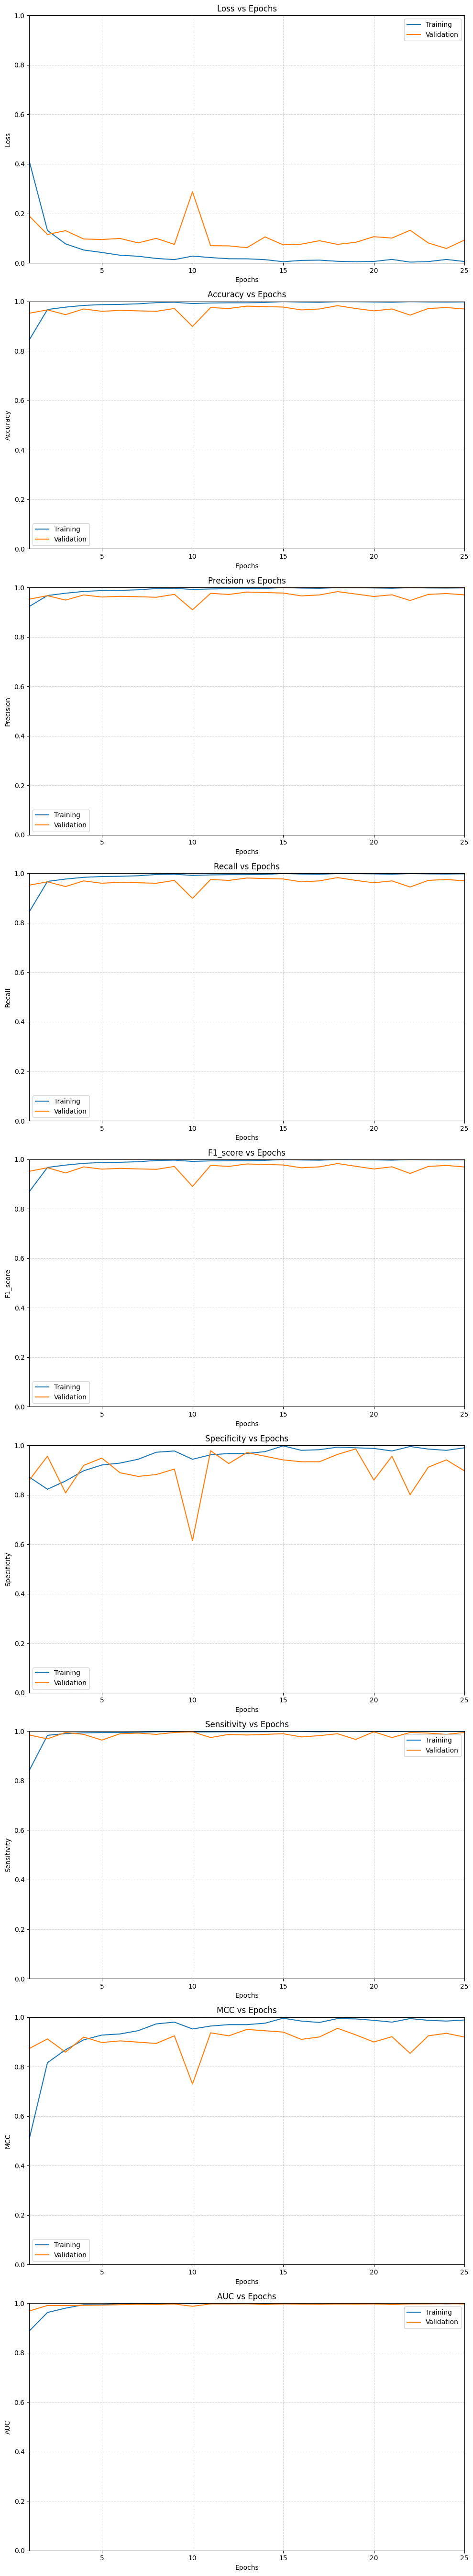

In [17]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))
    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(f"{metric_name.upper()} vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(f"{metric_name.capitalize()} vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        # Adjust xlim to avoid identical low and high limits.
        if num_epochs == 1:
            ax.set_xlim(0.5, 1.5)
        else:
            ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [18]:
# Testing loop
model.eval()
total_test_loss = 0.0
all_test_predictions = []
all_test_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_test_loss += loss.item()

        all_test_predictions.extend(outputs.detach().cpu().numpy())
        all_test_targets.extend(targets.detach().cpu().numpy())

all_test_predictions = np.array(all_test_predictions)
all_test_targets = np.array(all_test_targets)

average_test_loss = total_test_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_test_predictions), torch.tensor(all_test_targets), average_test_loss)
testing_metrics_line = "Test Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in test_metrics.items()])
print(testing_metrics_line)

Testing Model: 100%|██████████| 104/104 [00:02<00:00, 50.46it/s]

Test Metrics - loss: 1.1725, accuracy: 0.8093, precision: 0.8539, recall: 0.8093, f1_score: 0.7894, specificity: 0.4915, sensitivity: 1.0000, mcc: 0.6136, auc: 0.9202


In [19]:
# Convert true_labels and predicted_labels to numpy arrays
true_labels = np.array(all_test_targets)

# Assuming predicted_labels are probabilities, convert them to class labels
predicted_labels = np.argmax(np.array(all_test_predictions), axis=1)

# Ensure both true_labels and predicted_labels are of integer type
true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

# # Option 2: if using ImageFolder
# classes = dataset.classes

# Class names in correct index order
class_name_map = {
    0: "Normal",
    1: "Pneumonia Present",
}
classes = [class_name_map[i] for i in sorted(class_name_map.keys())]

# Get class names from the dataset
# classes = train_dataset.classes

# classes = label_encoder.classes_

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                   precision    recall  f1-score   support

           Normal     1.0000    0.4915    0.6590       234
Pneumonia Present     0.7662    1.0000    0.8676       390

         accuracy                         0.8093       624
        macro avg     0.8831    0.7457    0.7633       624
     weighted avg     0.8539    0.8093    0.7894       624

There were 119 errors in 624 tests for an accuracy of  80.93
